# GCI最終課題
このnotebookでは、予測結果を作成するまでの流れと基本的な手法についての紹介を行います。


まずは、今回のタスクについて確認しましょう（詳細はREADME.ipynbをご覧ください）。
- **目的**： 顧客データから解約をする確率を予測する。


## 目次
0. ライブラリ・データの読み込み
1. データの可視化と分析
2. 前処理と特徴量作成
3. 機械学習モデルの作成
4. モデル評価・混同行列

0. ライブラリ・データの読み込み

In [ ]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#　GoogleColabにドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#　csv file data を読み込む
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Final Assignment/telecom_client_sqlite3.csv" )
df_record = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Final Assignment/telecom_record_sqlite3.csv" )

0-1.データベースについて

電気通信事業会社A社の過去のデータが含まれたデータベースファイル「telecom.sqlite3」が配布されている
カラム名とその説明が明らかになっている（「4-3.カラムの説明」参照）
以下の情報が格納された2種類のテーブルが含まれている
顧客情報（Client）
利用履歴（Record）


2種類のテーブルが含まれている

顧客情報（Client）
利用履歴（Record）

をひとつのテーブル(df_con)にまとめて可視化と分析をする。

In [ ]:
#　DataFrame表示で、すべてのrowsとcolumnsを表示できる設定にして、データの確認をしやすくする。
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
#　telecom.sqlite3の顧客情報（Client） 利用履歴（Record）を見やすく結合したDataFrame=df_conをpd.concatで作成する。
df_con = pd.concat([df, df_record], axis=1)

1. データの可視化と分析

### 1_1 データの概観
本格的な分析を行う前に、まずは簡単にデータの概観を確認します。

In [ ]:
# telecom.sqlite3の顧客情報（Client） 利用履歴（Record）を見やすく結合したDataFrame=df_conのデータを確認する。
print(f"df_con shape: {df_con.shape}")
df_con.head(3)

df_con shape: (100000, 100)


,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months
0,2,1,U,A,N,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,S,1.0,M,4.0,3.0,C,A,0.0,N,U,U,U,U,U,Y,361.0,1000001,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.0,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61
1,1,1,N,EA,N,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,NaN,7.0,6.0,WC,1.0,1.0,NaN,1.0,S,S,1.0,M,5.0,1.0,C,A,0.0,Z,U,U,U,U,U,Y,240.0,1000002,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.0,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,0,56
2,1,1,Y,C,N,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,NaN,0.0,0.0,O,7.0,S,M,2.0,M,5.0,2.0,C,A,0.0,N,U,Y,U,U,U,Y,1504.0,1000003,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.0,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.000000,1,58


In [ ]:
#　DataFrame=df_conの要約情報を確認する。
df_con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   uniqsubs          100000 non-null  int64  
 1   actvsubs          100000 non-null  int64  
 2   new_cell          100000 non-null  object 
 3   crclscod          100000 non-null  object 
 4   asl_flag          100000 non-null  object 
 5   totcalls          100000 non-null  int64  
 6   totmou            100000 non-null  float64
 7   totrev            100000 non-null  float64
 8   adjrev            100000 non-null  float64
 9   adjmou            100000 non-null  float64
 10  adjqty            100000 non-null  int64  
 11  avgrev            100000 non-null  float64
 12  avgmou            100000 non-null  float64
 13  avgqty            100000 non-null  float64
 14  avg3mou           100000 non-null  int64  
 15  avg3qty           100000 non-null  int64  
 16  avg3rev           10

In [ ]:
#　DataFrame=df_conの統計要約情報を確認する。
df_con.describe()

,uniqsubs,actvsubs,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,hnd_price,phones,models,truck,rv,lor,adults,income,numbcars,forgntvl,eqpdays,Customer_ID,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,97161.000000,97161.000000,97161.000000,99153.000000,99999.000000,99999.000000,98268.000000,98268.000000,69810.000000,76981.000000,74564.000000,50634.000000,98268.000000,99999.000000,1.000000e+05,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99643.000000,99109.000000,99109.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.548140,1.358960,2877.141930,7648.363833,1031.924988,960.111528,7546.314699,2836.366920,57.913832,483.726493,173.554507,519.641210,180.337320,59.193330,509.634576,178.365157,58.683618,101.875763,1.787118,1.545825,0.188820,0.082580,6.177238,2.530326,5.783112,1.567563,0.057974,391.932309,1.050000e+06,58.719985,513.559937,46.179136,0.888828,41.072247,13.559560,13.295062,0.261318,1.286405,-13.933818,-1.021067,5.955085,0.040520,4.022917,0.025777,27.784905,0.029810,144.881677,0.870548,55.085152,0.047590,108.892535,0.774442,1.790838,4.666880,3.683328,29.766550,0.284720,227.763520,1.844036,111.654562,24.753320,28.467865,7.894360,18.193037,88.480285,0.358162,174.080788,0.707832,66.003498,0.416283,165.280703,1.135804,10.044298,145.752225,109.666977,0.011700,1.782928,0.495620,18.833990
std,1.075255,0.655555,3790.863474,8666.558293,852.907511,840.170815,8594.889729,3756.513882,36.161292,438.485213,167.824576,533.634073,192.725835,46.695429,496.663453,182.724565,40.758577,61.005671,1.313977,0.898395,0.391368,0.275248,4.735267,1.452819,2.182132,0.625456,0.233696,256.482193,2.886766e+04,46.291677,525.168140,23.623489,2.177619,97.296150,30.500885,30.056089,3.126531,14.711374,276.087509,50.363209,8.954715,0.877136,10.672202,1.490255,38.358734,0.496970,158.267711,9.053901,86.841198,2.127422,118.580079,8.129844,5.315570,12.761953,10.539981,55.833753,1.092101,264.403894,23.733226,162.691285,34.414822,48.962903,16.145590,41.421462,103.066103,4.065630,207.673553,8.410151,91.456885,4.652627,237.332918,17.768683,15.418406,159.348094,119.594305,0.547470,5.353953,0.499983,9.655794
min,1.000000,0.000000,0.000000,0.000000,3.650000,2.400000,0.000000,0.000000,0.480000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-2.000000,9.989998,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,-5.000000,1.000001e+06,-6.167500,0.000000,-26.915000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3875.000000,-1107.740000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

#### 1_2 各特徴量の可視化・分析
ここでは、各特徴量について可視化を行い、どのような特徴があるのか分析します。

電気通信事業会社A社のデータ分析のPoC(★)の発注のモチベーションを想像してみる。

【テーマ】

利潤追求がモチベーションの基礎であると考える。
ついては、顧客の解約防止をデータ分析にもとづいて提案することを企画することにする。

【目的変数】
churn カラムを目的変数として設定する。

【データ分析の目標】
churn 予想をデータ分析の目的として、これをプレゼンテーション商品と位置づける。

【スキーム】

そのための社会状況を外部データ（総務省などの公的情報を活用する）で分析する。

電気通信事業会社A社から提供された顧客情報（Client）と利用履歴（Record）の情報に探索的データ分析を実施する。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f746c81eee0>,
      dtype=object)

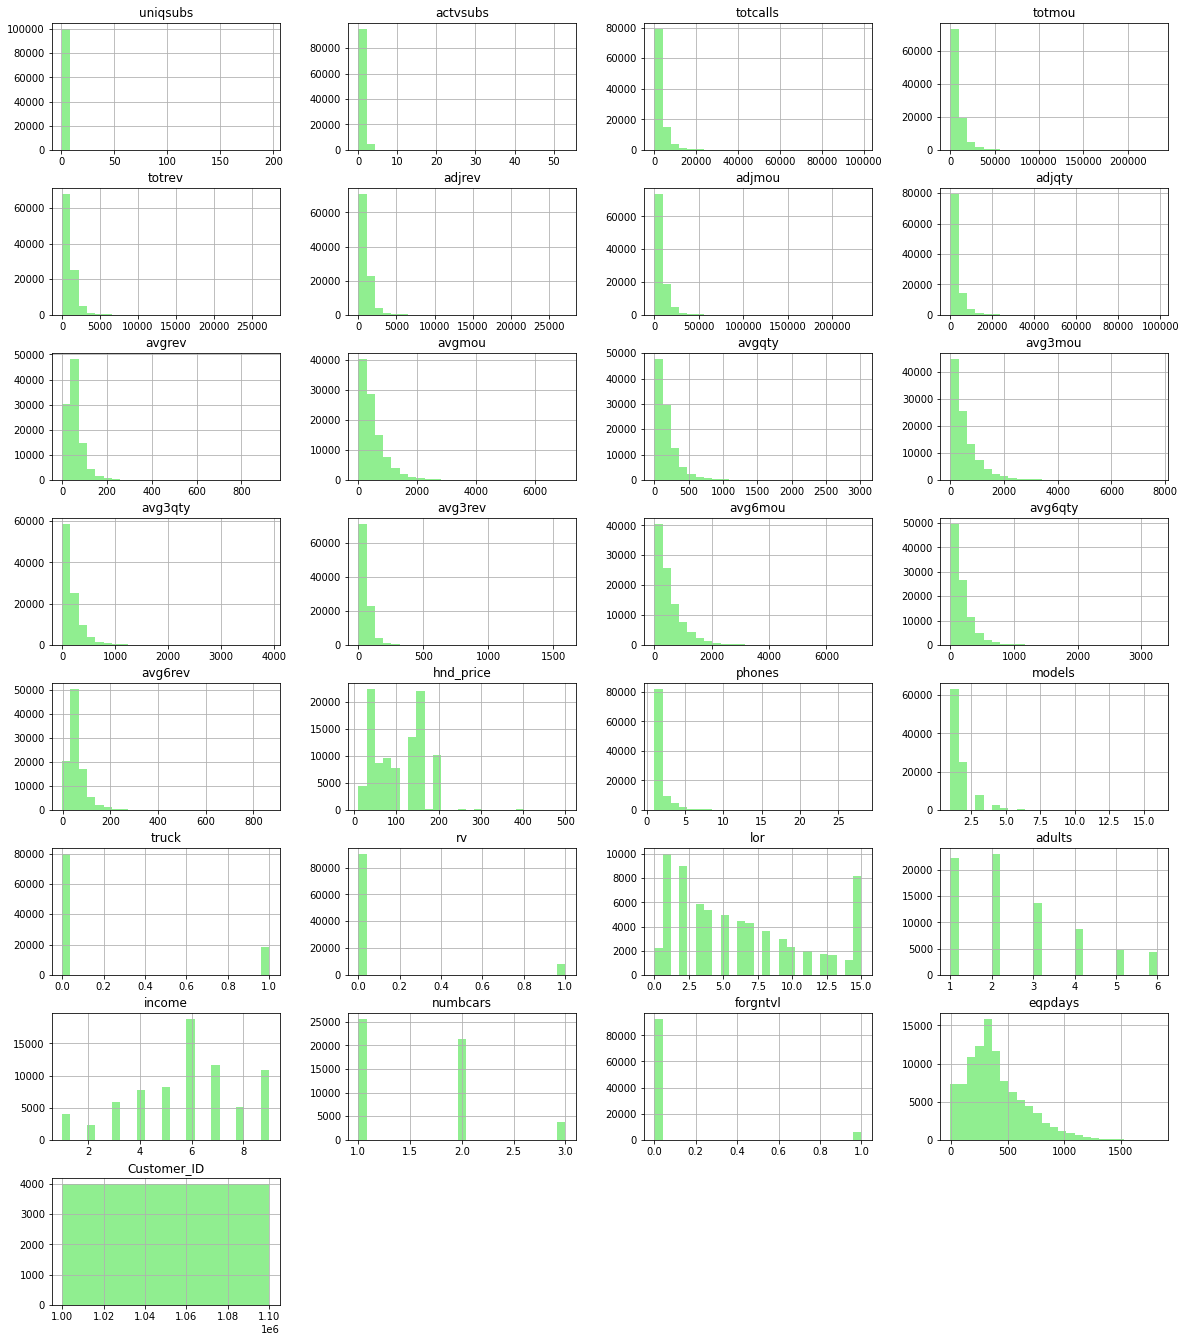

In [ ]:
#　顧客情報（Client）DataFrameを.hist関数で可視化して概観する。
df.iloc[:,:].hist(color="lightgreen", bins=25,figsize=(20,60),layout=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f746dfc1790>,
      dtype=object)

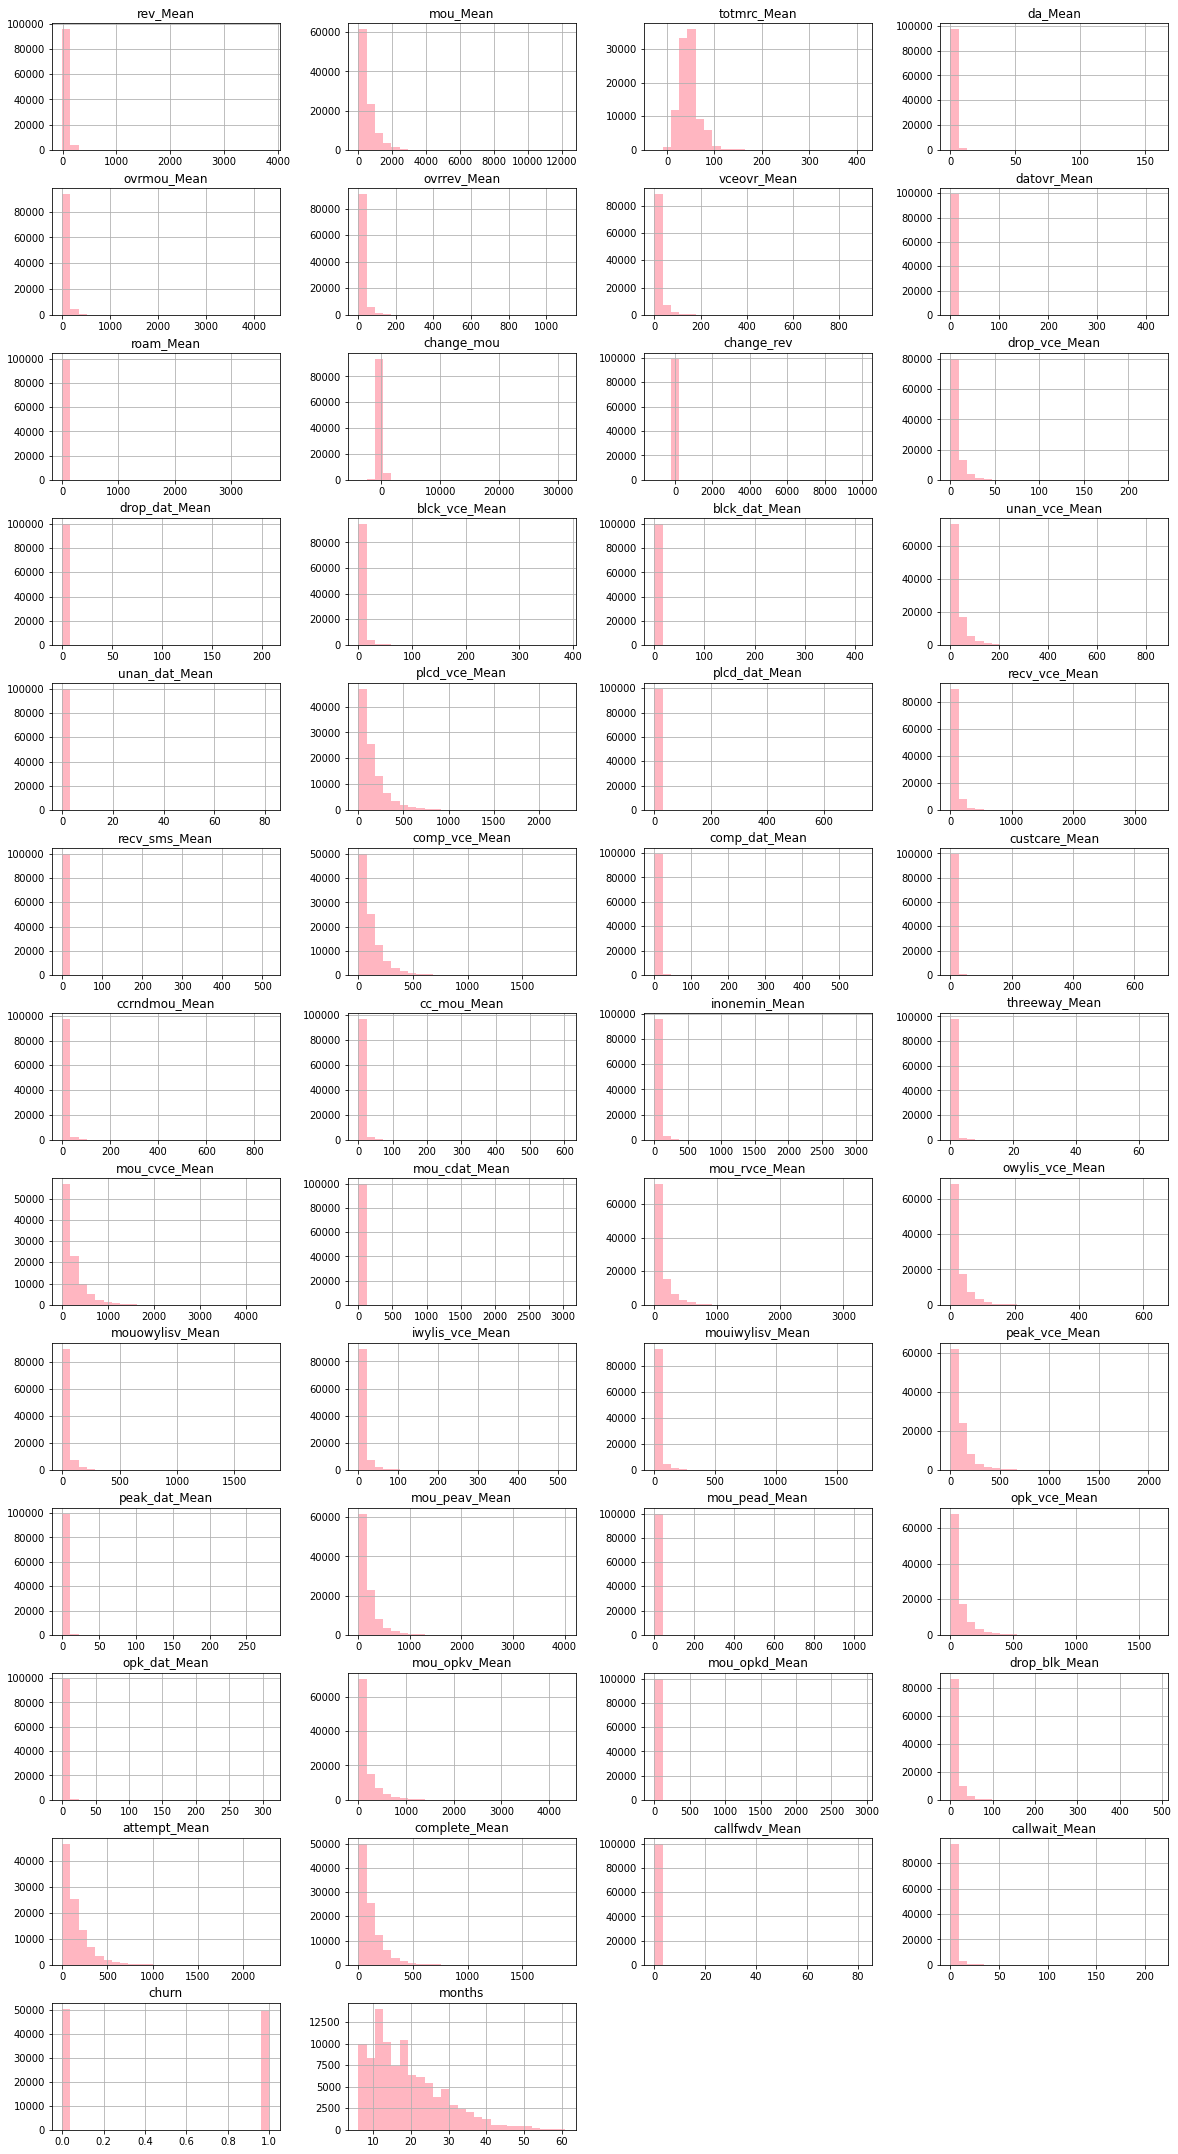

In [ ]:
#　利用履歴（Record）DataFrameを.hist関数で可視化して概観する。
df_record.iloc[:,:].hist(color="lightpink", bins=25,figsize=(20,60),layout=(20,4))

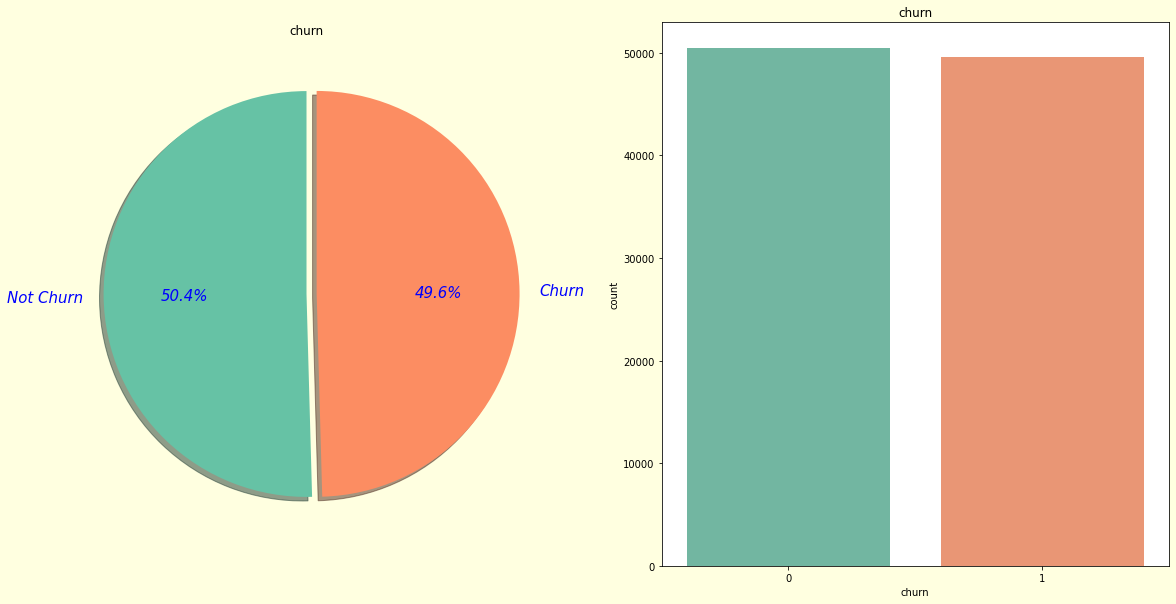

0    50438
1    49562
Name: churn, dtype: int64

In [ ]:
#　matplotlibのメソッドを使用してDataFrane=df_conのchurnカラムのグラフ表示をする。
f,ax=plt.subplots(1,2,figsize=(20,10), facecolor='lightyellow')
sns.set_palette('Set2')

label = ["Not Churn", "Churn"]

df_con['churn'].value_counts().plot.pie(explode=[0,0.05],autopct='%1.1f%%',ax=ax[0],shadow=True, labels=label, startangle=90, counterclock=True, textprops={"color": "blue", "size": 15, "style": "italic"})
ax[0].set_title('churn')
ax[0].set_ylabel('')

sns.countplot('churn',data=df_con,ax=ax[1])
ax[1].set_title('churn')

plt.show()
df_con['churn'].value_counts()

In [ ]:
#　契約月数monthsと解約churnとの関連性を分析したい。
#　契約月数monthsと解約churnをグループ化.groupbyして並び替.sort_valuesしてビン分割.groupby(pd.qcut(df2['months'], 4))して割合表示df4する。
df1 = df_con.groupby('months')['churn'].sum().reset_index()
df2 = df1.sort_values(by='churn', ascending=False)
df3 = df1.groupby(pd.qcut(df2['months'], 4)).sum()
df4 = (df3['churn'] * 100 / df_con['churn'].sum()).round(2)
print(df1.head(2))
print(df2.head(2))
print(df3.churn.sum())
print(df3.churn)
print(df4)

   months  churn
0       6    497
1       7   1656
   months  churn
5      11   5229
6      12   3732
49562
months
(5.999, 19.75]    29833
(19.75, 33.5]     15558
(33.5, 47.25]      3595
(47.25, 61.0]       576
Name: churn, dtype: int64
months
(5.999, 19.75]    60.19
(19.75, 33.5]     31.39
(33.5, 47.25]      7.25
(47.25, 61.0]      1.16
Name: churn, dtype: float64


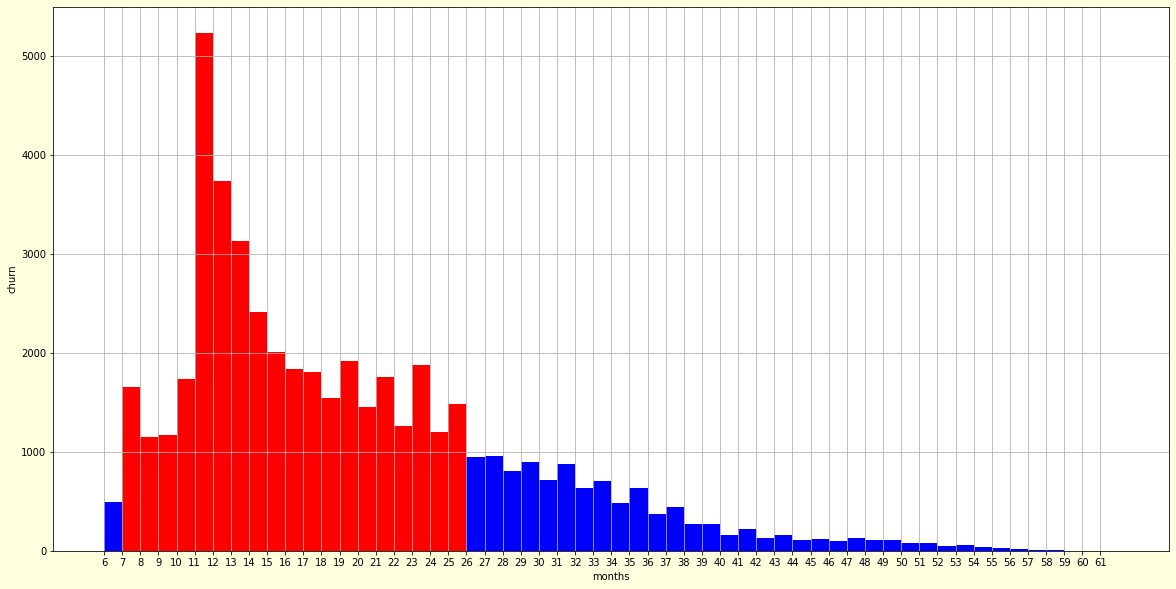

In [ ]:
#　上記で処理したプロセスを.bar関数で視覚化したい。matplotlibの.barメソッドを使用する。

f,ax=plt.subplots(1,figsize=(20,10), facecolor='lightyellow')
# 表示するデータ
x = df1.months
y = df1.churn
plt.bar(x, y, align='edge', width = 1, color = [('blue' if i < 999 else 'red') for i in y])
# 棒グラフそれぞれのラベル
plt.xticks(x, df1.months)
# xとyのラベルを設定
plt.xlabel('months')
plt.ylabel('churn')
# グリッドを表示
plt.grid(True)

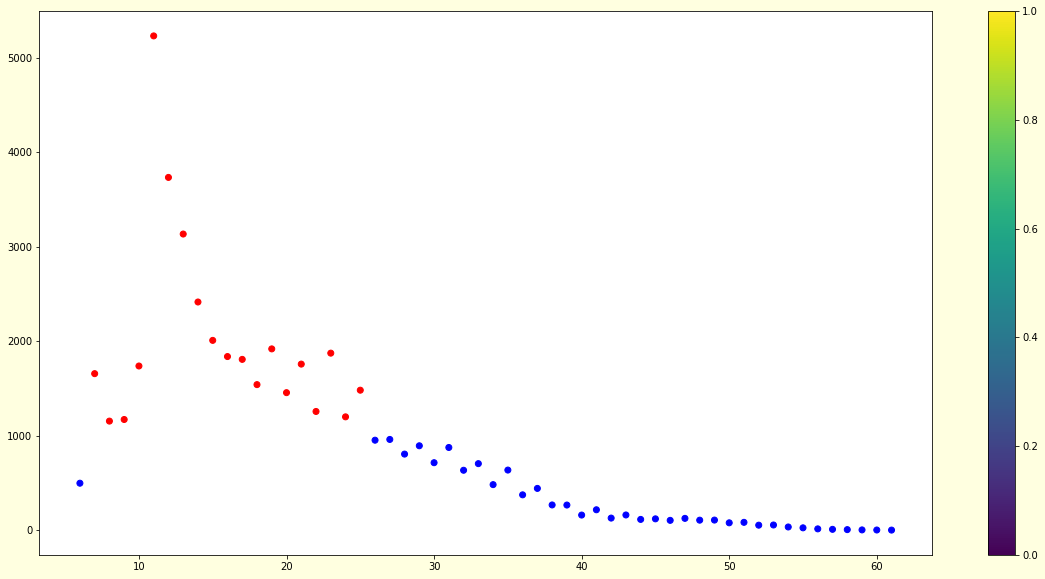

In [ ]:
#　上記で処理したプロセスを.scatter関数で視覚化したい。matplotlibの.scatterメソッドを使用する。

f,ax=plt.subplots(1,figsize=(20, 10), facecolor='lightyellow')
# 表示するデータ
x = df1.months
y = df1.churn
# グラフの大きさ指定  
plt.scatter(x, y, color = [('blue' if i < 999 else 'red') for i in y])
# カラーバーを表示
plt.colorbar()

In [ ]:
#　カスタマーケアコールの平均数custcare_Meanと解約churnとの関連性を分析したい。
#　カスタマーケアコールの平均数custcare_Meanと解約churnをグループ化.groupbyして並び替.sort_valuesしてビン分割.groupby(pd.qcut(df2['months'], 4))して割合表示df4する。
df1_ana = df_con.groupby('months')['churn', 'custcare_Mean'].sum().reset_index()
df2_ana = df1_ana.sort_values(by='churn', ascending=False)
df3_ana = df1_ana.groupby(pd.qcut(df1_ana['months'], 4)).sum()
df4_ana = (df3_ana['custcare_Mean'] * 100 / df_con['custcare_Mean'].sum()).round(2)
df5 = df3_ana['custcare_Mean']
print(df1_ana.head(2))
print(df2_ana.head(2))
print(df3_ana.churn.sum())
print(df3_ana.churn)
print(df3_ana)
print(df5)

   months  churn  custcare_Mean
0       6    497    4570.666667
1       7   1656   16609.000000
   months  churn  custcare_Mean
5      11   5229   16896.833333
6      12   3732   11834.333333
49562
months
(5.999, 19.75]    29833
(19.75, 33.5]     15558
(33.5, 47.25]      3595
(47.25, 61.0]       576
Name: churn, dtype: int64
                months  churn  custcare_Mean
months                                      
(5.999, 19.75]     175  29833  129873.833333
(19.75, 33.5]      371  15558   40117.666666
(33.5, 47.25]      567   3595    8203.666667
(47.25, 61.0]      763    576     888.666667
months
(5.999, 19.75]    129873.833333
(19.75, 33.5]      40117.666666
(33.5, 47.25]       8203.666667
(47.25, 61.0]        888.666667
Name: custcare_Mean, dtype: float64


In [ ]:
#　解約churnにたいしての関与の強さを知りたい。
#　カスタマーケアコールの平均数custcare_Meanと解約churnとの比率を確認する。
df1_ana['ratio'] = (df1_ana['churn'] / df1_ana['custcare_Mean'])
print(df1_ana.churn.sum())
print(df1_ana.head(2))

49562
   months  churn  custcare_Mean     ratio
0       6    497    4570.666667  0.108737
1       7   1656   16609.000000  0.099705


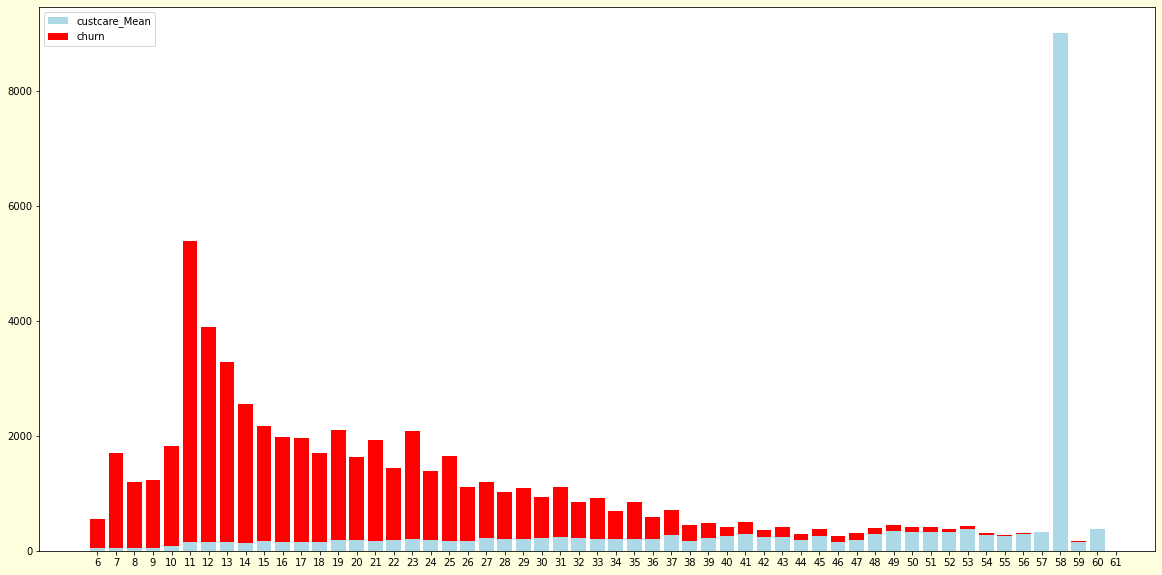

In [ ]:
#　上記で処理したプロセスを視覚化したい。matplotlibの.barメソッドを使用する。

f,ax=plt.subplots(1,figsize=(20,10), facecolor='lightyellow')
# データの準備
height1 = df1_ana.ratio * 500
height2 = df1_ana.churn
# X軸
x = df1_ana.months
# plt.xticks(df1_ana.months)
# グラフの描画
p1 = plt.bar(x, height1, color = 'lightblue')
p2 = plt.bar(x, height2, bottom = height1, color='red')
plt.xticks(x, df1_ana.months)
# 凡例を表示 
plt.legend((p1[0], p2[0]), ('custcare_Mean', 'churn'))

In [ ]:
#　カスタマー ケア コールの平均使用時間 (分)ccrndmou_Meanと解約churnとの関連性を分析したい。
#　カスタマー ケア コールの平均使用時間 (分)ccrndmou_Meanと解約churnをグループ化.groupbyして並び替.sort_valuesしてビン分割.groupby(pd.qcut(df2['months'], 4))して割合表示df4する。
df1_ana_ccrndmou = df_con.groupby('months')['churn', 'ccrndmou_Mean'].sum().reset_index()
df2_ana_ccrndmou = df1_ana_ccrndmou.sort_values(by='churn', ascending=False)
df3_ana_ccrndmou = df1_ana_ccrndmou.groupby(pd.qcut(df1_ana_ccrndmou['months'], 4)).sum()
df4_ana_ccrndmou = (df3_ana_ccrndmou['ccrndmou_Mean'] * 100 / df_con['ccrndmou_Mean'].sum()).round(2)
df6 = df3_ana_ccrndmou['ccrndmou_Mean']
print(df1_ana_ccrndmou.head(2))
print(df2_ana_ccrndmou.head(2))
print(df3_ana_ccrndmou.churn.sum())
print(df3_ana_ccrndmou.churn)
print(df3_ana_ccrndmou)
print(df6)

   months  churn  ccrndmou_Mean
0       6    497   11129.666667
1       7   1656   40161.000000
   months  churn  ccrndmou_Mean
5      11   5229   41912.333333
6      12   3732   29709.000000
49562
months
(5.999, 19.75]    29833
(19.75, 33.5]     15558
(33.5, 47.25]      3595
(47.25, 61.0]       576
Name: churn, dtype: int64
                months  churn  ccrndmou_Mean
months                                      
(5.999, 19.75]     175  29833  331819.333332
(19.75, 33.5]      371  15558  107828.000000
(33.5, 47.25]      567   3595   23956.333333
(47.25, 61.0]      763    576    3084.333333
months
(5.999, 19.75]    331819.333332
(19.75, 33.5]     107828.000000
(33.5, 47.25]      23956.333333
(47.25, 61.0]       3084.333333
Name: ccrndmou_Mean, dtype: float64


In [ ]:
#　解約churnにたいしての関与の強さを知りたい。
#　カスタマー ケア コールの平均使用時間 (分)ccrndmou_Meanと解約churnとの比率を確認する。
df1_ana_ccrndmou['ratio'] = (df1_ana_ccrndmou['churn'] / df1_ana_ccrndmou['ccrndmou_Mean'])
print(df1_ana_ccrndmou.churn.sum())
print(df1_ana_ccrndmou.head(2))

49562
   months  churn  ccrndmou_Mean     ratio
0       6    497   11129.666667  0.044655
1       7   1656   40161.000000  0.041234


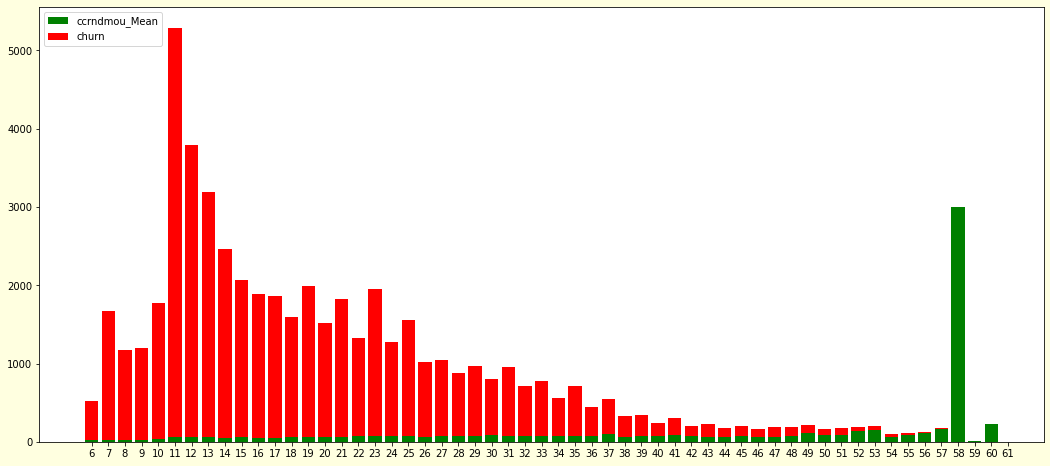

In [ ]:
#　上記で処理したプロセスを視覚化したい。matplotlibの.barメソッドを使用する。

f,ax=plt.subplots(1,figsize=(18,8), facecolor='lightyellow')
# データの準備
height1 = df1_ana_ccrndmou.ratio * 500
height2 = df1_ana_ccrndmou.churn
# X軸
x = df1_ana_ccrndmou.months
# グラフの描画
p1 = plt.bar(x, height1, color = 'green')
p2 = plt.bar(x, height2, bottom = height1, color='red')
plt.xticks(x, df1_ana_ccrndmou.months)
# 凡例を表示 
plt.legend((p1[0], p2[0]), ('ccrndmou_Mean', 'churn'))

In [ ]:
#　世帯内の有効な加入者数actvsubsと解約churnとの関連性を分析したい。
#　世帯内の有効な加入者数actvsubsと解約churnをグループ化.groupbyして並び替.sort_valuesしてビン分割.groupby(pd.qcut(df2['months'], 4))して割合表示df4する。
df1_ana_act = df_con.groupby('actvsubs')['churn'].sum().reset_index()
df2_ana_act = df1_ana_act.sort_values(by='churn', ascending=False)
df3_ana_act = df1_ana_act.groupby(pd.qcut(df1_ana_act['actvsubs'], 4)).sum()
df4_ana_act = (df3_ana_act['churn'] * 100 / df_con['churn'].sum()).round(2)
df11 = df3_ana_act['churn']
print(df1_ana_act.head(20))
print(df2_ana_act.head(20))
print(df3_ana_act.churn.sum())
print(df3_ana_act.churn)
print(df3_ana_act)
print(df11)
print(df4_ana_act)

    actvsubs  churn
0          0     33
1          1  34326
2          2  12752
3          3   1857
4          4    462
5          5    111
6          6     10
7          7      2
8          8      5
9          9      3
10        11      0
11        53      1
    actvsubs  churn
1          1  34326
2          2  12752
3          3   1857
4          4    462
5          5    111
0          0     33
6          6     10
8          8      5
9          9      3
7          7      2
11        53      1
10        11      0
49562
actvsubs
(-0.001, 2.75]    47111
(2.75, 5.5]        2430
(5.5, 8.25]          17
(8.25, 53.0]          4
Name: churn, dtype: int64
                actvsubs  churn
actvsubs                       
(-0.001, 2.75]         3  47111
(2.75, 5.5]           12   2430
(5.5, 8.25]           21     17
(8.25, 53.0]          73      4
actvsubs
(-0.001, 2.75]    47111
(2.75, 5.5]        2430
(5.5, 8.25]          17
(8.25, 53.0]          4
Name: churn, dtype: int64
actvsubs
(-0.001, 2.

In [ ]:
#　解約churnにたいしての関与の強さを知りたい。
#　カスタマーケアコールの平均数custcare_Meanと解約churnとの比率を確認する。
#df1_ana_act['ratio'] = (df1_ana_act['churn'] / df1_ana_act['actvsubs'])
df1_ana_act['ratio'] = (df1_ana_act['churn'] * 100 / df1_ana_act['churn'].sum()).round(2) 
print(df1_ana_act.churn.sum())
print(df1_ana_act.ratio.head(24))

49562
0      0.07
1     69.26
2     25.73
3      3.75
4      0.93
5      0.22
6      0.02
7      0.00
8      0.01
9      0.01
10     0.00
11     0.00
Name: ratio, dtype: float64


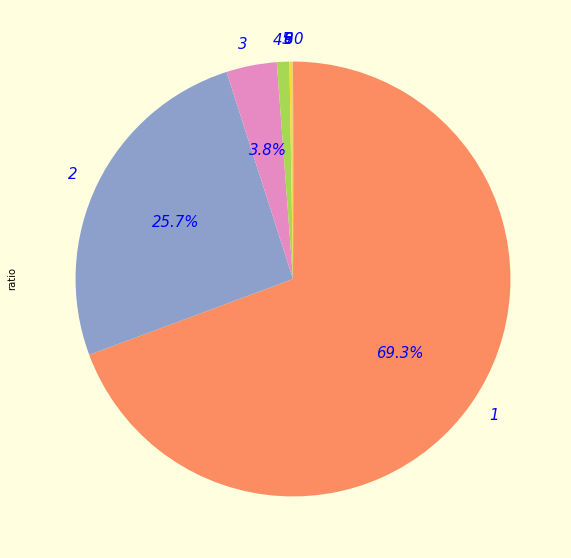

0      0.1
1     69.3
2     25.7
3      3.8
4      0.9
5      0.2
6      0.0
7      0.0
8      0.0
9      0.0
10     0.0
11     0.0
Name: ratio, dtype: float64

In [ ]:
#　上記で処理したプロセスを視覚化したい。matplotlibの.pieメソッドを使用する。
f,ax=plt.subplots(1,figsize=(20,10), facecolor='lightyellow')
sns.set_palette('Set2')
df1_ana_act['ratio'].plot.pie(autopct=lambda p: '{:.1f}%'.format(p) if p >= 3.7 else '', startangle=90, counterclock=False, textprops={"color": "blue", "size": 15, "style": "italic"})
plt.show()
df1_ana_act['ratio'].round(1) 

2. 前処理と特徴量作成

特徴量を絞り込みます。特徴量としての採用は、カラム[９]とカラム[１０]の可視化されたヒストグラム一覧を確認して決定します。具体的には、グラフデータに数値の"傾向"が読み取れるカラムを採用します。例＝df_record[months] etc...  
逆に、数値に"動き"や"傾向"のないデータは採用しません。例＝df[Customer_ID]etc...

In [ ]:
# 上記のテキストに記した基準により、特徴量を絞り込む。
df_con = df_con[['churn', 'actvsubs', 'ccrndmou_Mean', 'ccrndmou_Mean', 'months', 'custcare_Mean', 'complete_Mean', 'attempt_Mean', 'mou_peav_Mean', 'mou_cvce_Mean', 'mou_rvce_Mean', 'opk_vce_Mean',
                 'peak_vce_Mean', 'owylis_vce_Mean', 'comp_vce_Mean', 'plcd_vce_Mean', 'mou_Mean', 'totmrc_Mean', 'eqpdays', 'income', 'lor', 'adults', 'numbcars', 'hnd_price', 'avg6rev', 'avg6qty',
                 'avg6mou', 'avg3rev', 'avg3qty', 'avg3mou', 'avgqty', 'avgmou', 'avgrev', 'adjqty', 'adjmou', 'adjrev', 'totrev', 'totmou', 'totcalls']]

In [ ]:
#　カラムの数を数えてみます。
print(len(df_con.columns))

39


In [ ]:
#　カラム[２４]であらたにカラムを絞り込んだDataFrame=df_conを.head()のデフォルト値５行を表示してみます。
df_con.head()

,churn,actvsubs,ccrndmou_Mean,ccrndmou_Mean,months,custcare_Mean,complete_Mean,attempt_Mean,mou_peav_Mean,mou_cvce_Mean,mou_rvce_Mean,opk_vce_Mean,peak_vce_Mean,owylis_vce_Mean,comp_vce_Mean,plcd_vce_Mean,mou_Mean,totmrc_Mean,eqpdays,income,lor,adults,numbcars,hnd_price,avg6rev,avg6qty,avg6mou,avg3rev,avg3qty,avg3mou,avgqty,avgmou,avgrev,adjqty,adjmou,adjrev,totrev,totmou,totcalls
0,1,1,0.000000,0.000000,61,0.000000,45.000000,52.333333,132.600000,90.643333,97.176667,24.000000,58.000000,0.000000,45.000000,52.333333,219.25,22.500,361.0,4.0,15.0,1.0,3.0,149.98999,38.0,136.0,322.0,30,116,272,32.69,83.37,29.66,1602,4085.00,1453.44,1504.62,4228.00000,1652
1,0,1,6.333333,6.333333,56,1.666667,193.333333,263.333333,75.333333,189.396667,55.280000,157.000000,83.666667,46.333333,193.333333,263.333333,482.75,37.425,240.0,5.0,1.0,1.0,1.0,NaN,48.0,275.0,477.0,40,158,305,265.89,479.40,51.53,14624,26367.00,2833.88,2851.68,26400.00000,14654
2,1,1,0.000000,0.000000,58,0.000000,6.000000,9.000000,5.193333,5.426667,0.000000,1.000000,5.000000,0.000000,6.000000,9.000000,10.25,16.990,1504.0,5.0,7.0,2.0,2.0,29.98999,17.0,6.0,11.0,17,7,12,140.86,433.98,34.54,7888,24303.05,1934.47,2155.91,24385.05333,7903
3,0,1,0.000000,0.000000,60,0.000000,3.666667,3.666667,3.380000,8.410000,0.413333,3.666667,1.333333,0.333333,3.666667,3.666667,7.50,38.000,1812.0,6.0,6.0,4.0,1.0,29.98999,40.0,25.0,50.0,38,3,8,30.81,63.23,40.45,1479,3035.00,1941.81,2000.90,3065.00000,1502
4,0,1,15.000000,15.000000,57,8.666667,137.000000,222.333333,173.476667,285.233333,106.330000,90.333333,97.333333,14.666667,137.000000,222.333333,570.50,71.980,434.0,6.0,5.0,1.0,1.0,149.98999,80.0,196.0,586.0,55,191,558,79.50,249.38,38.69,4452,13965.00,2166.48,2181.12,14028.00000,4485


#### fillnaで埋める
他の処理として、`fillna`（値）で、`NaN`になっている箇所をある値で埋める方法もあります。たとえば`NaN`を0として扱うケースです。次のように`fillna(0)`とすると、`NaN`が0に置き変わります。

In [ ]:
df_con = df_con.fillna(0)

In [ ]:
# 顧客情報（Client）と利用履歴（Record）を結合したDataFrame=df_conのカテゴリカルデータをOne-Hot Encodingして上書きしたDataFrame=df_conの欠損値を確認する。
df_con.isnull().sum()
print(df_con.isnull().sum())

churn              0
actvsubs           0
ccrndmou_Mean      0
ccrndmou_Mean      0
months             0
custcare_Mean      0
complete_Mean      0
attempt_Mean       0
mou_peav_Mean      0
mou_cvce_Mean      0
mou_rvce_Mean      0
opk_vce_Mean       0
peak_vce_Mean      0
owylis_vce_Mean    0
comp_vce_Mean      0
plcd_vce_Mean      0
mou_Mean           0
totmrc_Mean        0
eqpdays            0
income             0
lor                0
adults             0
numbcars           0
hnd_price          0
avg6rev            0
avg6qty            0
avg6mou            0
avg3rev            0
avg3qty            0
avg3mou            0
avgqty             0
avgmou             0
avgrev             0
adjqty             0
adjmou             0
adjrev             0
totrev             0
totmou             0
totcalls           0
dtype: int64


#### fillnaで埋める
他の処理として、`fillna`（値）で、`NaN`になっている箇所をある値で埋める方法もあります。たとえば`NaN`を0として扱うケースです。次のように`fillna(0)`とすると、`NaN`が0に置き変わります。

3. 機械学習モデルの作成

## 3_1 ベースラインモデルの構築

　モデルの構築に入ります。モデルの構築においては、まずベースラインとなるモデルを作成することが多いです。ベースラインモデルは、機械学習モデルが学習できる形にデータが整形されているか確認することや、改良されたモデルと比較して改良の効果を評価することが主な目的です。ベースラインモデルは、あまり学習に時間のかからないモデルを用います。ここでは、ベースラインモデルとしてよく用いられるランダムフォレストを使用します。ランダムフォレストのアルゴリズムについては講義で学びますが、簡単に説明すると複数の決定木の多数決によって予測を行う機械学習モデルになります。  
　まずdfとdf_testを**説明変数**と**目的変数**に分けます。
- 説明変数：モデルの学習に使用する変数、今回の問題ではPassengerId, Perished以外の変数
- 目的変数：予測対象の変数, 今回の問題ではPerished 

　ここでスライスしたdfとdf_testを.valuesとしてnumpy.ndarray型に変換しているのは、機械学習モデルの実装によってはこの型のデータしか受け付けないからです。

In [ ]:
#  説明変数と目的変数を用意する。
X = df_con.drop(['churn'], axis=1).values
y = df_con['churn'].values

In [ ]:
#  訓練データと検証データを分割する。
#　引数にshuffle=Trueを指定して毎回データをシャッフルした訓練データと検証データを用意する。
#  訓練データは７割、検証データは３割に分割する。test_size=0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

### 3_2 ランダムフォレスト、勾配ブースティング
キーワード：ランダムフォレスト、勾配ブースティング、変数の重要度、Partial Dependence Plots

本節では、バギングとブースティングの中でも代表的なものである**ランダムフォレスト（Random Forest）**と**勾配ブースティング（Gradient Boosting）**の使い方を紹介します。いずれも、ベースとしているアルゴリズムは決定木です。

アンサンブル学習を手軽に実行する場合、上記のいずれかのアルゴリズムが採用されるケースが多いです。機械学習の初学者であれば、考え方を8.3.1と8.3.2で理解し、実際のモデル構築はこれらアルゴリズムで行うというスタートが良いと思われます。

またモデル結果の解釈性が優先される場合は、ロジスティック回帰や決定木など、よりシンプルなモデルを採用した方が良い局面もあることは留意しておきましょう。

　ランダムフォレストモデルを作成して、擬似訓練データ(X_train, y_train)を学習させます。ランダムフォレストモデルを作成する際に指定できる主な引数は以下の通りです。不明な用語がいくつかあるかもしれませんが、いずれ講義で解説があります。またこれら以外にも様々な引数があるので、公式ドキュメントなどを参照してみてください。
- max_depth：決定木の深さの最大値
- max_features：それぞれの決定木に、どれくらいの特徴量を使用するか
- min_samples_leaf：葉が含むサンプル数の最小値
- n_estimators：決定木の数
- n_jobs：計算に用いるスレッド数
- random_state：乱数生成のシード値

In [ ]:
rfc = RandomForestClassifier(random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [ ]:
print('Train Score: {}'.format(round(rfc.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(rfc.score(X_test, y_test), 3)))

Train Score: 1.0
 Test Score: 0.604


　訓練データに対する正解率が約66%であるのに対して、テストデータに対する正解率が約60%となっています。**過学習**が発生している状況となっています。テストデータに対して良い予測を得るためにはこの状況を改善することが不可欠です。  
　過学習を解決するためには機械学習の**ハイパーパラメータ**を調整する必要があります。ハイパーパラメータとは、機械学習モデルを作成する際に予め指定する必要のあるパラメータであり、データを学習しても更新されません。ランダムフォレストモデルの場合はmax_depth(決定木の深さの最大値)やmin_samples_leaf(葉が含むサンプル数の最小値)などがそれにあたります。例えば、max_depthの値を大きく設定するほど過学習の傾向が強まりますが、逆にmax_depthの値が小さすぎるとそもそもモデルの精度が得られません（この状況を過学習に対して**未学習**と呼びます）。  
　過学習に起因する誤差を**バリアンス**、未学習に起因する誤差を**バイアス**と呼びますが、バリアンスとバイアスはトレードオフの関係にあります。そのため良いモデルを作成するためには、バリアンスとバイアスの両方を抑えられるようなハイパーパラメータを見つける必要があります。このようなハイパーパラメータを見つける方法には、**グリッドサーチ**と呼ばれるものや、**ベイズ最適化**を用いるものなどがあります。ここではグリッドサーチを紹介します。  
　グリッドサーチとは、複数のハイパーパラメータを同時に最適化するため，離散的に指定されたハイパーパラメータの組に基づいて，しらみつぶしにモデルの予測精度を評価する手法です。ここではmax_depthの候補として(４，６，８，１０)max_featuresの候補として('sqrt', 'log2')min_samples_leafの候補として(１，２，４，６)n_estimatorsの候補として(１０，５０，１００）を取ってみましょう。

In [ ]:
param_grid = {'max_depth': [4, 6, 8, 10],
              'max_features': ['sqrt', 'log2'],
              'min_samples_leaf': [1, 2, 4, 6],
              'n_estimators': [10, 50, 100]}
for max_depth in param_grid['max_depth']:
  for max_features in param_grid['max_features']:
    for min_samples_leaf in param_grid['min_samples_leaf']:
      for n_estimators in param_grid['n_estimators']:
        rfc_grid = RandomForestClassifier(max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, 
                                          n_estimators=n_estimators, n_jobs=-1, random_state=42)
        rfc_grid.fit(X_train, y_train)
        print('max_depth: {}, max_features: {}, min_samples_leaf: {}, n_estimators: {}'.format(max_depth, max_features, min_samples_leaf, n_estimators))
        print('    Train Score: {}, Test Score: {}'.format(round(rfc_grid.score(X_train, y_train), 3),
                                                           round(rfc_grid.score(X_test, y_test), 3)))

max_depth: 4, max_features: sqrt, min_samples_leaf: 1, n_estimators: 10
    Train Score: 0.591, Test Score: 0.59
max_depth: 4, max_features: sqrt, min_samples_leaf: 1, n_estimators: 50
    Train Score: 0.589, Test Score: 0.587
max_depth: 4, max_features: sqrt, min_samples_leaf: 1, n_estimators: 100
    Train Score: 0.588, Test Score: 0.586
max_depth: 4, max_features: sqrt, min_samples_leaf: 2, n_estimators: 10
    Train Score: 0.591, Test Score: 0.59
max_depth: 4, max_features: sqrt, min_samples_leaf: 2, n_estimators: 50
    Train Score: 0.589, Test Score: 0.587
max_depth: 4, max_features: sqrt, min_samples_leaf: 2, n_estimators: 100
    Train Score: 0.588, Test Score: 0.586
max_depth: 4, max_features: sqrt, min_samples_leaf: 4, n_estimators: 10
    Train Score: 0.591, Test Score: 0.59
max_depth: 4, max_features: sqrt, min_samples_leaf: 4, n_estimators: 50
    Train Score: 0.59, Test Score: 0.587
max_depth: 4, max_features: sqrt, min_samples_leaf: 4, n_estimators: 100
    Train Score: 

　このグリッドサーチは、先に軽く触れた**クロスバリデーション**と組み合わせて行われることが多いです。クロスバリデーションはホールドアウト法の拡張となっています。ホールドアウト法では訓練データを擬似訓練データと擬似テストデータの二つに分けましたが、クロスバリデーションでは自然数Nを指定してデータをN個に分割します。こうして分割されたN個のデータのうち1つを擬似テストデータ、残りを擬似訓練データとして学習と評価を行います。N個のデータがそれぞれ一回ずつ擬似テストデータとなるようN回の学習と評価を行い、得られたスコアの平均をそのモデルのスコアとします。下図を参照してください。  
　このようにすることで、モデルの擬似テストデータに対するスコアがデータの分割方法に依らなくなることが期待されます。ホールドアウト法では、データを2つに分けてしまうため、データの分割方法によっては擬似訓練データと擬似テストデータに偏りが生じてしまいますが、クロスバリデーションではそのような可能性が平均操作により軽減されます。

![](http://musashi.osdn.jp/tutorial/mining/xtclassify/nfold.jpg)

　今回は訓練データを５分割してクロスバリデーションしてみましょう。

In [ ]:
rfc_gs = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=42), param_grid, cv=5)
rfc_gs.fit(X, y)

print('Best Parameters: {}'.format(rfc_gs.best_params_))
print('CV Score: {}'.format(round(rfc_gs.best_score_, 3)))

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'n_estimators': 100}
CV Score: 0.581


In [ ]:
rfc = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=6, 
                                  n_estimators=100, n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)
print('max_depth: {}, max_features: {}, min_samples_leaf: {}, n_estimators: {}'.format(max_depth, max_features, min_samples_leaf, n_estimators))
print('    Train Score: {}, Test Score: {}'.format(round(rfc.score(X_train, y_train), 3),
                                                   round(rfc.score(X_test, y_test), 3)))

max_depth: 10, max_features: log2, min_samples_leaf: 6, n_estimators: 100
    Train Score: 0.667, Test Score: 0.611


4. モデル評価・混同行列


続いて混同行列を取得していきます。混同行列は、`sklearn.metrics`モジュールの`confusion_matrix`関数で取得できます。出力される数値の並びは先の図で記した通り、列に予測値（`y_pred`）、行に観測値（`y_test`）が、正例・負例の順に並びます。

In [ ]:
# インポート
from sklearn.metrics import confusion_matrix

# テストデータを使って予測値を算出
y_pred = rfc.predict(X_test)

m = confusion_matrix(y_test, y_pred)
print('Confution matrix:\n{}'.format(m))

Confution matrix:
[[8395 6693]
 [4975 9937]]


In [ ]:
accuracy = (m[0, 0] + m[1, 1]) / m.sum()
print('正解率:{:.3f}'.format(accuracy))

正解率:0.611


In [ ]:
# 適合率の計算
precision = (m[1,1])/m[:, 1].sum()

# 再現率の計算
recall = (m[1,1])/m[1, :].sum()

# F1スコアの計算
f1 = 2 * (precision * recall)/(precision + recall)

print('適合率:{:.3f}'.format(precision))
print('再現率:{:.3f}'.format(recall))
print('F1値:{:.3f}'.format(f1))

適合率:0.598
再現率:0.666
F1値:0.630


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('適合率:{:.3f}'.format(precision_score(y_test, y_pred)))
print('再現率:{:.3f}'.format(recall_score(y_test, y_pred)))
print('F1値:{:.3f}'.format(f1_score(y_test, y_pred)))

適合率:0.598
再現率:0.666
F1値:0.630


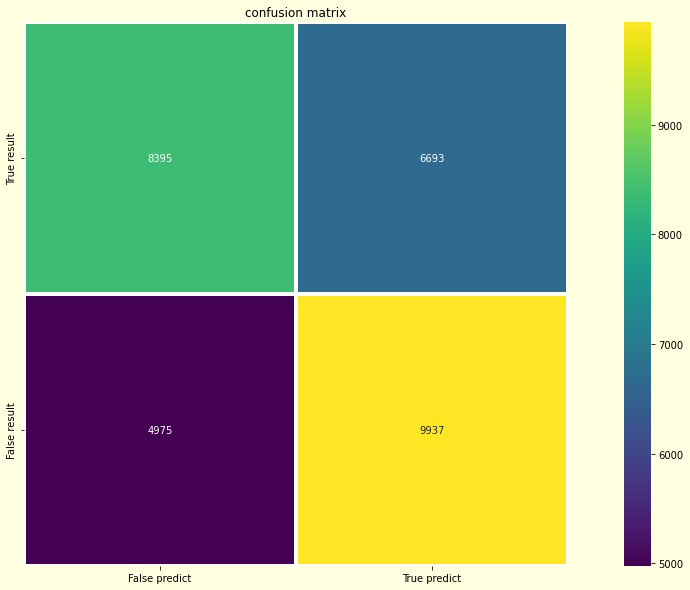

In [ ]:
#plt.figure(figsize = (10,7), facecolor='lightyellow')
fig, ax = plt.subplots(figsize=(20,10), facecolor='lightyellow')
sns.heatmap(m, annot=True, fmt='d', cmap='viridis', linewidths=3, square=True)
#sns.heatmap(m, annot=True, fmt="d", cmap="rainbow")
ax.set_title('confusion matrix')
ax.set_xticklabels(['False predict', 'True predict'])
ax.set_yticklabels(['True result', 'False result'])
plt.show()

比較モデルとしてロジスティック回帰モデルを構築

In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

print('Logistic Regression \n')
print('Train Score: {}'.format(round(lr.score(X_train, y_train), 3)))
print(' Test Score: {}'.format(round(lr.score(X_test, y_test), 3)))

Logistic Regression 

Train Score: 0.57
 Test Score: 0.563


比較モデル＝ロジスティック回帰モデルを混同行列で評価

In [ ]:
# インポート
#from sklearn.metrics import confusion_matrix

# テストデータを使って予測値を算出
y_pred_lr = lr.predict(X_test)

mm = confusion_matrix(y_test, y_pred_lr)
print('Confution matrix:\n{}'.format(mm))

Confution matrix:
[[8957 6131]
 [6965 7947]]


In [ ]:
accuracy = (mm[0, 0] + mm[1, 1]) / mm.sum()
print('正解率:{:.3f}'.format(accuracy))

正解率:0.563


In [ ]:
# 適合率の計算
precision = (mm[1,1])/mm[:, 1].sum()

# 再現率の計算
recall = (mm[1,1])/mm[1, :].sum()

# F1スコアの計算
f2 = 2 * (precision * recall)/(precision + recall)

print('適合率:{:.3f}'.format(precision))
print('再現率:{:.3f}'.format(recall))
print('F2値:{:.3f}'.format(f2))

適合率:0.564
再現率:0.533
F2値:0.548


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('適合率:{:.3f}'.format(precision_score(y_test, y_pred_lr)))
print('再現率:{:.3f}'.format(recall_score(y_test, y_pred_lr)))
print('F1値:{:.3f}'.format(f1_score(y_test, y_pred_lr)))

適合率:0.564
再現率:0.533
F1値:0.548


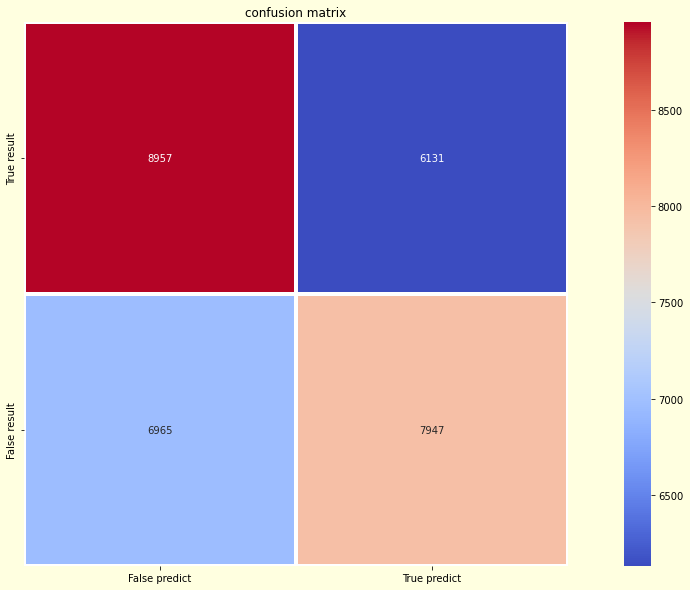

In [ ]:
#plt.figure(figsize = (10,7), facecolor='lightyellow')
fig, ax = plt.subplots(figsize=(20,10), facecolor='lightyellow')
#sns.heatmap(mm, annot=True, fmt='d', cmap='viridis', linewidths=3, square=True)
sns.heatmap(mm, annot=True, fmt='d', cmap='coolwarm', linewidths=3, square=True)
ax.set_title('confusion matrix')
ax.set_xticklabels(['False predict', 'True predict'])
ax.set_yticklabels(['True result', 'False result'])
plt.show()